In [2]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib

In [3]:
# Bibliotecas dos Modelos Utilizados
from sklearn.linear_model import LogisticRegression  # Regressão Logística.
from sklearn.svm import SVC                          # Máquinas de Vetores de Suporte (SVM).
from sklearn.neighbors import KNeighborsClassifier   # K-Vizinhos Mais Próximos
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [4]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [5]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Suspensao'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Suspensao
0,1403.343755,1464.830349,1384.813430,1650.169516,1931.095254,506.334809,84.391263,127.667651,0.400889,0.500616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1355.175580,1458.268851,1339.569317,1612.905747,1807.646429,NaN,85.875452,123.520084,0.446510,NaN,...,NaN,NaN,NaN,NaN,NaN,49.072302,NaN,5.699527,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1375.611808,1466.491046,1295.798366,1613.673946,1953.436224,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Altura do CG com relacao ao chao',
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'SD_Dimensoes dos pneus',
    'SD_Cambagem estatica',
    'SD_Convergência estatica',
    'ST_Curso Positivo de projeto',
    'ST_Curso Negativo de projeto',
    'ST_Dimensoes dos pneus',
    'ST_Cambagem estatica',
    'ST_Convergência estatica',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'MT_Potência maxima do motor',
    'MT_Torque maximo do motor',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal',
    'CD_Ganho de arfagem em desaceleracao longitudinal',
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida',
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [7]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DP_Entre-Eixo         779 non-null    float64
 1   DP_Bitola Dianteira   779 non-null    float64
 2   DP_Bitola Traseira    779 non-null    float64
 3   DP_Altura             779 non-null    float64
 4   DP_Comprimento        779 non-null    float64
 5   MV_Eixo dianteiro     761 non-null    float64
 6   MV_Eixo Traseiro      761 non-null    float64
 7   DMV_Dianteira         761 non-null    float64
 8   DMV_Lado Direito      291 non-null    float64
 9   PCG_X                 761 non-null    float64
 10  PCG_Y                 982 non-null    float64
 11  PCG_Z                 761 non-null    float64
 12  D_Relacao             613 non-null    float64
 13  MT_Relacao total_max  767 non-null    float64
 14  MT_Relacao total_min  755 non-null    float64
 15  P_Suspensao           

In [8]:
#Descrição de dados
df.describe()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,PCG_X,PCG_Y,PCG_Z,D_Relacao,MT_Relacao total_max,MT_Relacao total_min,P_Suspensao
count,779.000000,779.000000,779.000000,779.000000,779.000000,761.000000,761.000000,761.000000,291.000000,761.000000,982.000000,761.000000,613.000000,767.000000,755.000000,1000.000000
mean,1418.949410,1328.062802,1257.805115,1529.441658,2005.025052,75.420512,105.731786,0.416777,0.499509,269.186227,143.818033,54.411679,2.575716,28.094517,5.663805,3.000000
std,52.601655,66.041126,78.745504,183.528365,63.616710,11.755956,13.971030,0.028119,0.036484,265.267856,225.633064,4574.784412,0.644656,6.501579,1.573956,1.414921
min,1300.000000,881.424415,906.653036,283.775875,1767.135978,49.868677,78.230737,0.317883,0.169324,-255.720918,-104.790615,-123737.654930,1.042772,3.292976,0.460516,1.000000
25%,1381.921411,1288.574373,1204.507467,1497.144738,1975.629716,68.024917,97.055680,0.396254,0.483496,71.207837,-0.000472,183.192409,2.162214,26.112741,4.798252,2.000000
50%,1415.472742,1322.123147,1241.012326,1531.520302,2006.515887,73.047356,103.324393,0.416814,0.493429,134.294150,6.652776,254.560416,2.446957,28.619108,5.789269,3.000000
75%,1457.398788,1367.167825,1299.683041,1582.826332,2042.125129,79.164517,111.262270,0.436927,0.500743,490.503305,229.280242,401.404099,2.892730,31.731863,6.680780,4.000000
max,1602.304548,1555.934563,1489.252580,2393.897090,2187.559482,131.882184,156.788911,0.475935,0.689371,845.120992,1024.268514,721.079742,5.732285,44.945929,9.807661,5.000000


In [9]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.") 

'DP_Entre-Eixo' tem 0.
'DP_Bitola Dianteira' tem 0.
'DP_Bitola Traseira' tem 0.
'DP_Altura' tem 0.
'DP_Comprimento' tem 0.
'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'DMV_Lado Direito' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 35.
'PCG_Z' tem 0.
'D_Relacao' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'P_Suspensao' tem 0.


## Limpeza

In [10]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 300 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

DP_Entre-Eixo           221
DP_Bitola Dianteira     221
DP_Bitola Traseira      221
DP_Altura               221
DP_Comprimento          221
MV_Eixo dianteiro       239
MV_Eixo Traseiro        239
DMV_Dianteira           239
PCG_X                   239
PCG_Y                    18
PCG_Z                   239
MT_Relacao total_max    233
MT_Relacao total_min    245
P_Suspensao               0
dtype: int64

In [11]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 10]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([  2,   3,   5,   8,  12,  13,  14,  15,  17,  21,
            ...
            979, 980, 981, 983, 986, 987, 988, 991, 992, 999],
           dtype='int64', length=221)
     DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0      1403.343755          1464.830349         1384.813430  1650.169516   
1      1355.175580          1458.268851         1339.569317  1612.905747   
4      1375.611808          1466.491046         1295.798366  1613.673946   
6      1377.823365          1358.577746         1234.377233  1525.984408   
7      1453.776123          1500.000000         1412.056653  1542.274357   
..             ...                  ...                 ...          ...   
994    1438.236984          1350.000000         1280.351758  1670.627824   
995    1437.572127          1276.808399         1200.000000  1627.460455   
996    1430.487914          1257.233399         1206.112317  1701.632149   
997    1351.128586          1347.759384         1187.922132  

In [12]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Suspensao'] = df['P_Suspensao'].replace(mapeamento)

print(df['P_Suspensao'])

0      0
1      0
4      0
6      0
7      0
      ..
994    4
995    4
996    4
997    4
998    4
Name: P_Suspensao, Length: 779, dtype: int64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=False)

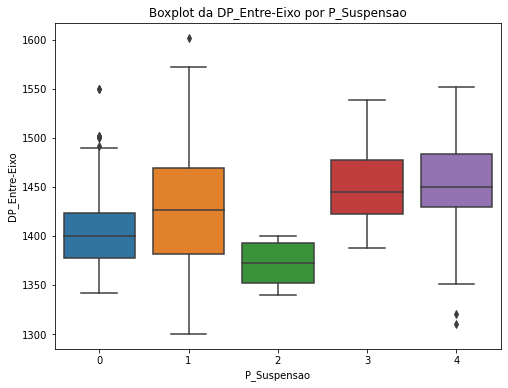

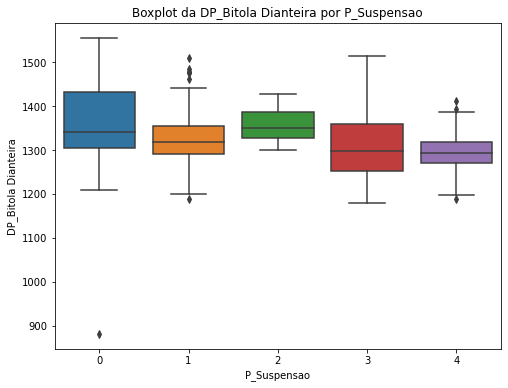

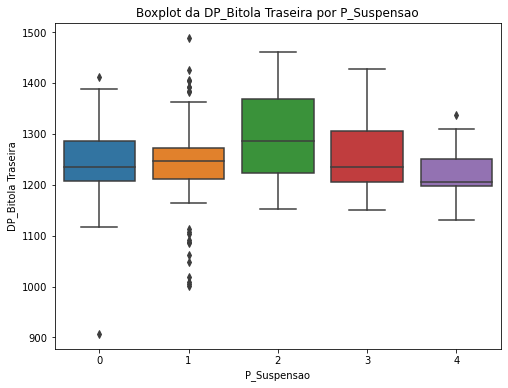

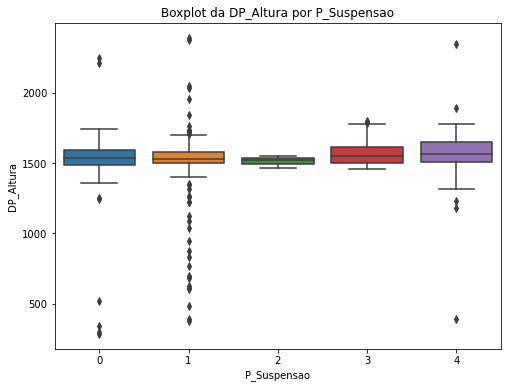

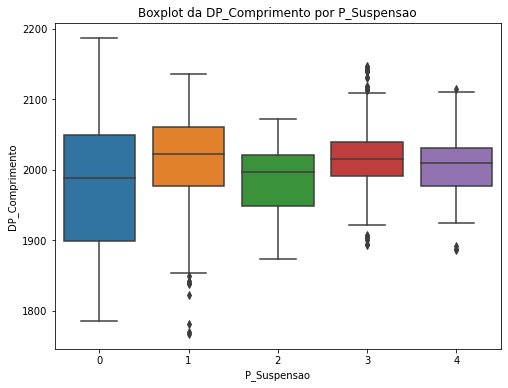

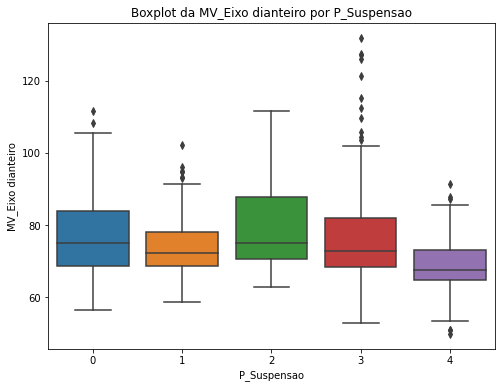

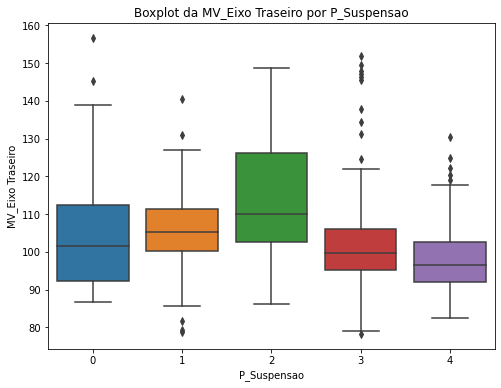

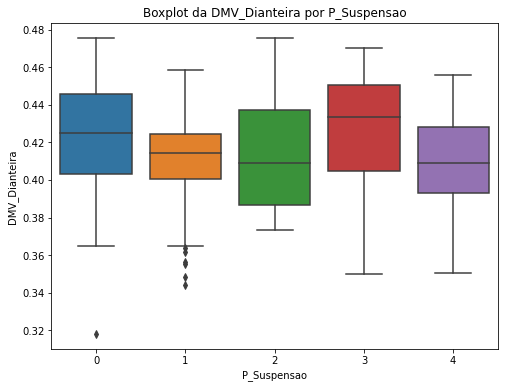

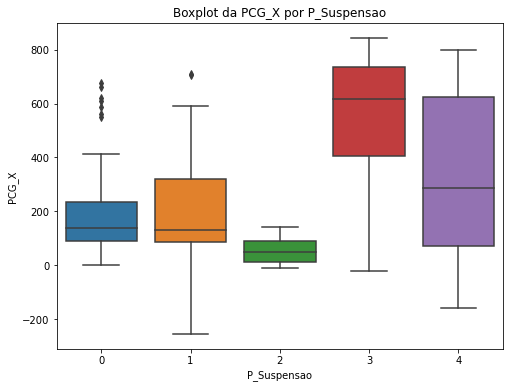

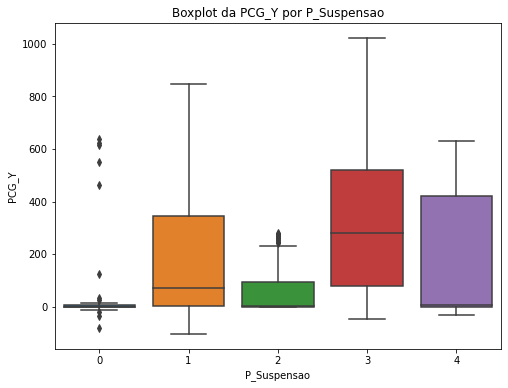

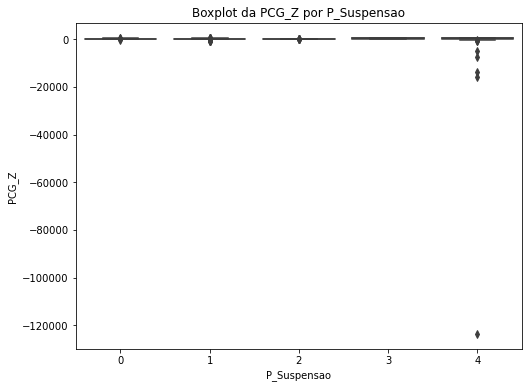

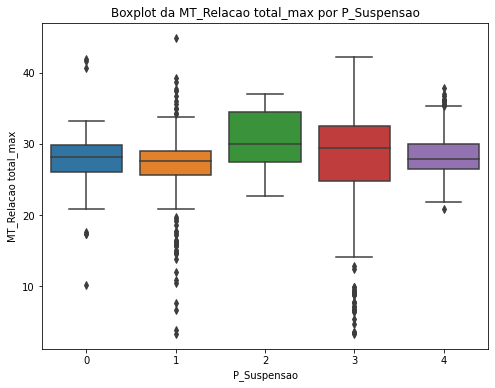

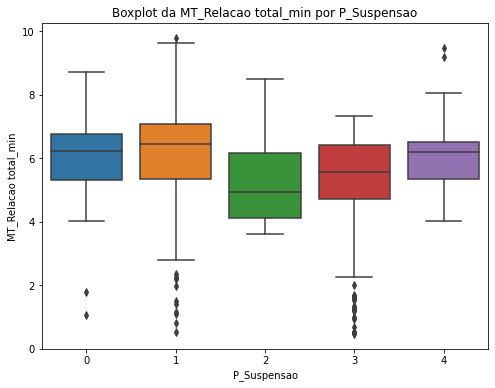

In [13]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Suspensao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Suspensao', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Suspensao')
        plt.ylabel(coluna)
        plt.xlabel('P_Suspensao')
        plt.show()

In [14]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Suspensao']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Suspensao'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Suspensao'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Suspensao'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

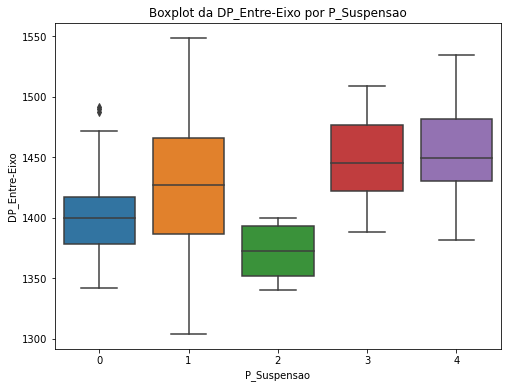

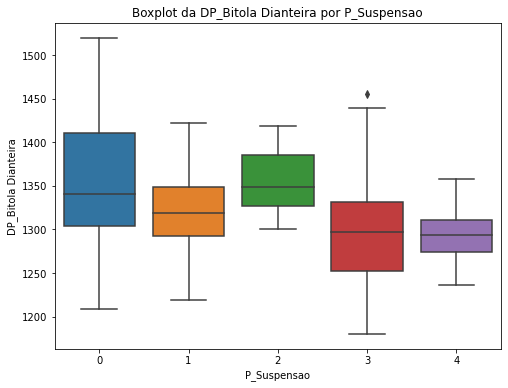

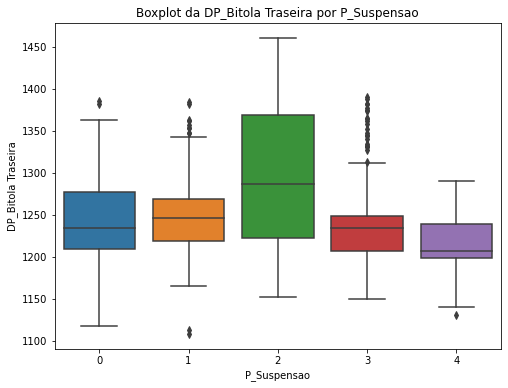

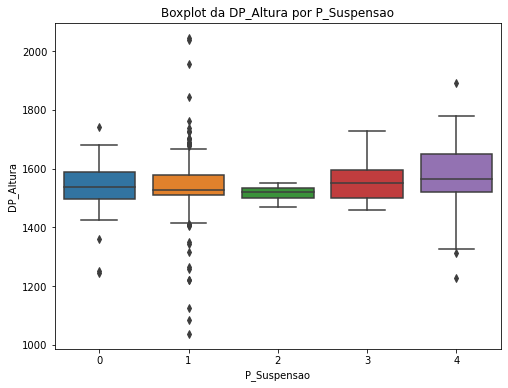

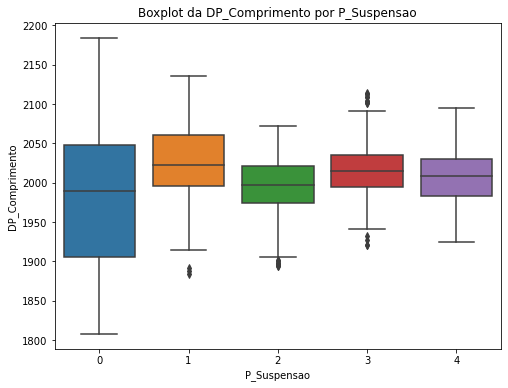

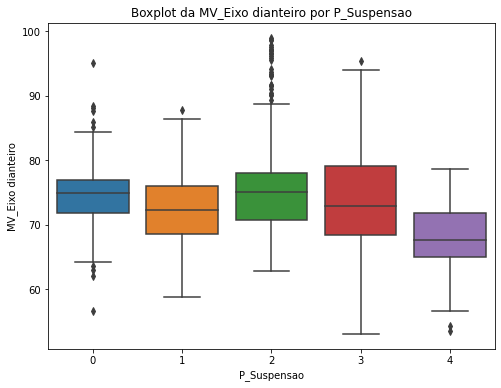

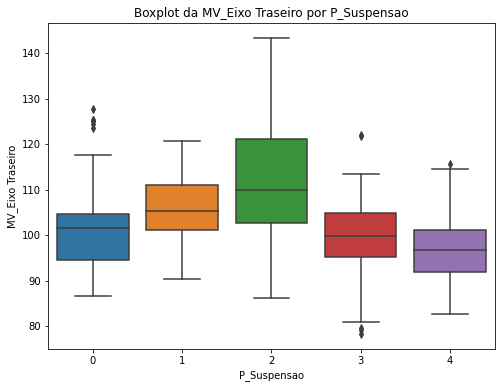

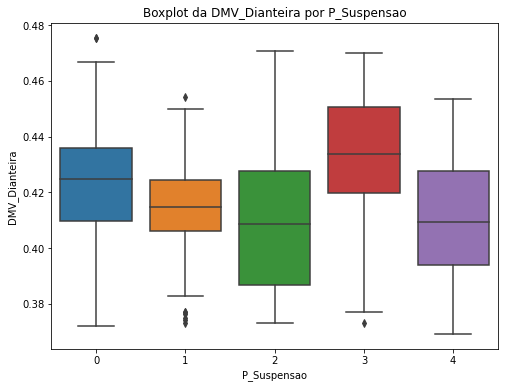

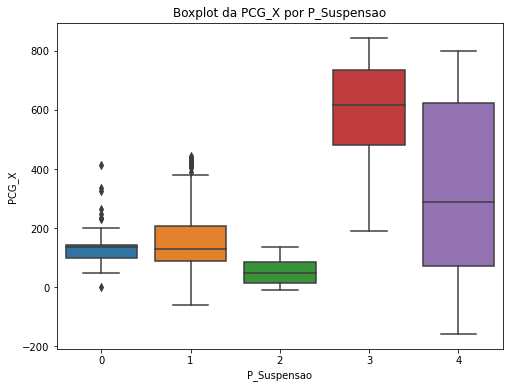

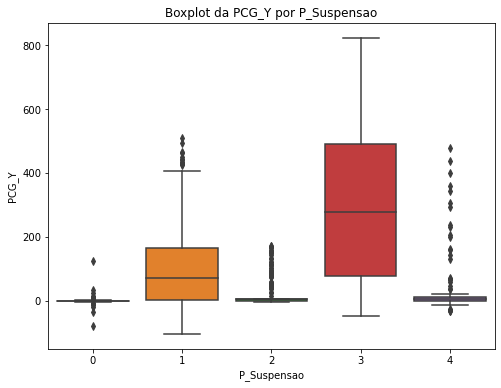

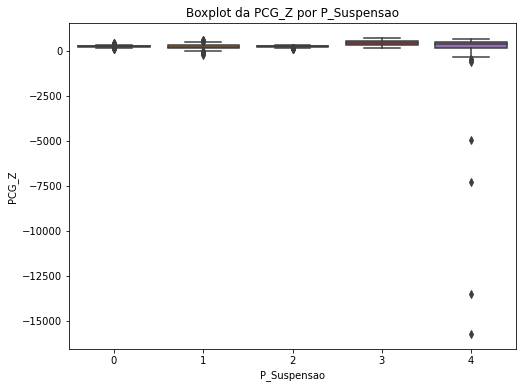

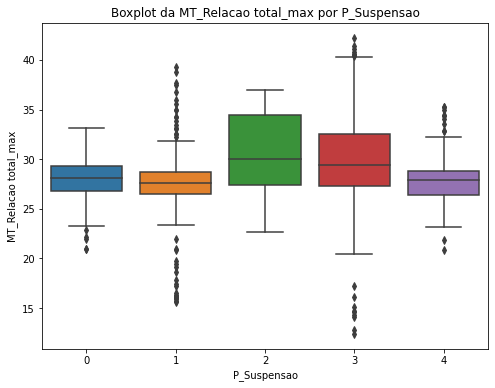

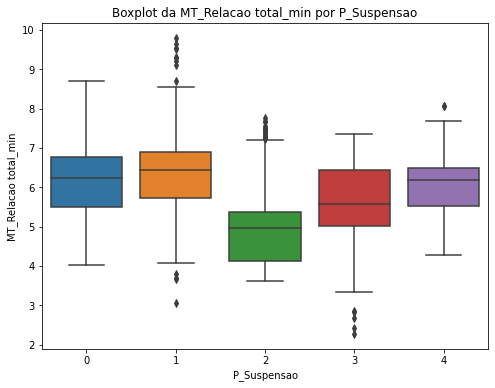

In [15]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Suspensao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Suspensao', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Suspensao')
        plt.ylabel(coluna)
        plt.xlabel('P_Suspensao')
        plt.show()

In [16]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [17]:
data_corr = df.drop(['P_Suspensao'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

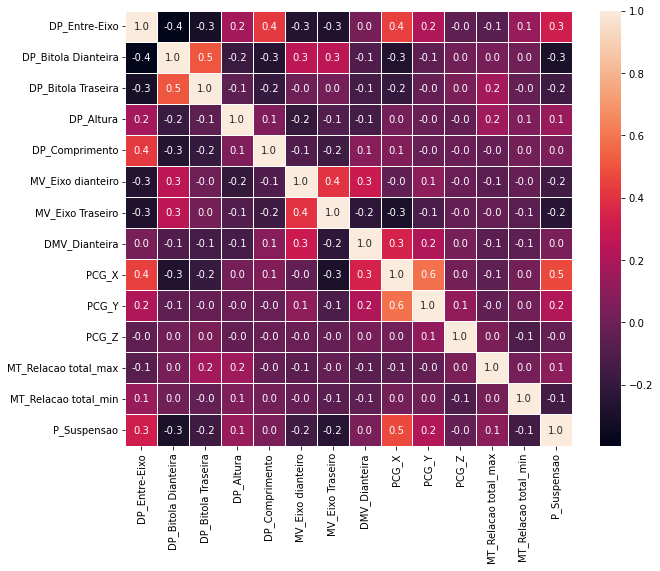

In [18]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [19]:
# Aplicar PCA para reduzir variáveis de alta correlação - DP_Bitola
variaveis_reduzidas = df[['DP_Bitola Dianteira', 'DP_Bitola Traseira']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 1

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'DP_Bitola', variavel_reduzida)

print(df)

     DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento  \
0      1403.343755  190.054439  1650.169516     1931.095254   
1      1355.175580  149.229464  1612.905747     1807.646429   
4      1375.611808  118.091006  1613.673946     1953.436224   
6      1377.823365    5.880318  1525.984408     2048.951826   
7      1453.776123   86.651597  1542.274357     2139.937218   
..             ...         ...          ...             ...   
994    1438.236984   38.619877  1670.627824     2029.885030   
995    1437.572127  -69.181647  1627.460455     2007.075820   
996    1430.487914  -75.402824  1701.632149     2030.654875   
997    1449.595684  -38.378324  1527.291742     1984.978929   
998    1430.000000  -55.879164  1600.000000     1965.000000   

     MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0            84.391263        127.667651       0.400889  236.156465   
1            85.875452        123.520084       0.446510  414.076579   
4            74.950803        

In [20]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_teste)

     DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento  \
921    1448.715335  -32.297027  1595.921025     2016.037324   
902    1449.595684   10.639002  1497.400033     2025.148622   
272    1450.207811    2.175758  1519.526280     2075.841129   
274    1367.787201  -66.415190  1527.150200     2000.000000   
805    1428.881554  -74.072597  1600.000000     1972.835186   
..             ...         ...          ...             ...   
603    1485.948691  -96.203857  1552.226075     2025.905704   
558    1360.815275  -76.633612  1511.057164     2033.864326   
421    1400.000000   45.684410  1489.764056     2001.023727   
268    1413.994065  -18.596469  1590.000000     2113.860245   
565    1378.298015  157.507841  1539.648212     1924.239857   

     MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
921          68.519019        105.686978       0.393076   66.644790   
902          71.762092         99.604708       0.420216  630.787564   
272          67.017149        

# Escolha do Modelo

## Regressão Logística:

In [21]:
# Modelo de regressão logística.
model_LR = LogisticRegression()
model_LR.fit(X_treino, Y_treino)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [22]:
# Avaliação do desempenho do modelo.
Y_pred = model_LR.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão Logística:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão Logística:
Acurácia: 0.64
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.33      0.11      0.16        19
           1       0.56      0.67      0.61        61
           2       0.67      0.84      0.74        61
           3       0.70      0.83      0.76        52
           4       0.72      0.32      0.44        41

    accuracy                           0.64       234
   macro avg       0.60      0.55      0.54       234
weighted avg       0.63      0.64      0.61       234



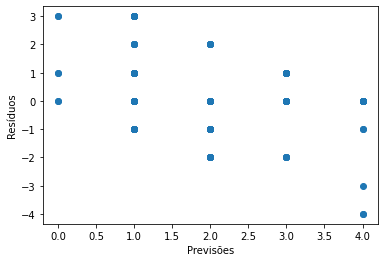

In [23]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Máquinas de Vetores de Suporte (SVM)

In [24]:
# Modelo SVM com um kernel linear e "um contra todos"
model_SVM = SVC(kernel='linear', decision_function_shape='ovr')
model_SVM.fit(X_treino, Y_treino)

SVC(kernel='linear')

In [25]:
# Avaliação do desempenho do modelo.
Y_pred = model_SVM.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Máquinas de Vetores de Suporte:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Máquinas de Vetores de Suporte:
Acurácia: 0.79
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.56      0.47      0.51        19
           1       0.75      0.80      0.78        61
           2       0.91      1.00      0.95        61
           3       0.75      0.88      0.81        52
           4       0.76      0.46      0.58        41

    accuracy                           0.79       234
   macro avg       0.75      0.72      0.73       234
weighted avg       0.78      0.79      0.77       234



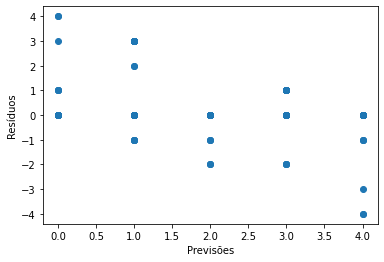

In [26]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## K-Nearest Neighbors

In [27]:
k = 3  # Número de vizinhos (Altere por necessidade)

# Modelo de K-Vizinhos Mais Próximos (K-Nearest Neighbors - KNN).
model_KNN = KNeighborsClassifier(n_neighbors=k)
model_KNN.fit(X_treino, Y_treino)

KNeighborsClassifier(n_neighbors=3)

In [28]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_KNN.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para K-Vizinhos Mais Próximos:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para K-Vizinhos Mais Próximos:
Acurácia: 0.79
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.45      0.53      0.49        19
           1       0.72      0.70      0.71        61
           2       0.88      0.98      0.93        61
           3       0.82      0.79      0.80        52
           4       0.91      0.76      0.83        41

    accuracy                           0.79       234
   macro avg       0.76      0.75      0.75       234
weighted avg       0.80      0.79      0.79       234



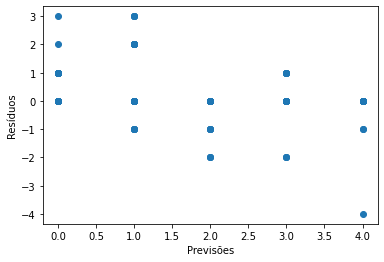

In [29]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Decision Tree Classifier

In [30]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

In [31]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_DTC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Árvore de Decisão de Classificação:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Árvore de Decisão de Classificação:
Acurácia: 0.80
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62        19
           1       0.72      0.62      0.67        61
           2       0.87      0.95      0.91        61
           3       0.87      0.90      0.89        52
           4       0.88      0.73      0.80        41

    accuracy                           0.80       234
   macro avg       0.77      0.79      0.78       234
weighted avg       0.80      0.80      0.80       234



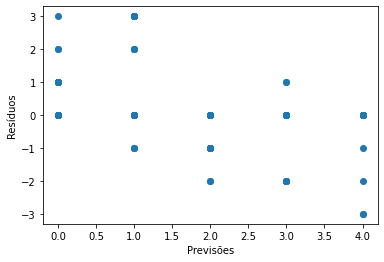

In [32]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Random Forest Classifier

In [33]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

In [34]:
# Avaliação do desempenho do modelo.
Y_pred = model_RFC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão de Floresta Aleatória:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão de Floresta Aleatória:
Acurácia: 0.88
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80        19
           1       0.84      0.89      0.86        61
           2       0.92      1.00      0.96        61
           3       0.83      0.92      0.87        52
           4       1.00      0.73      0.85        41

    accuracy                           0.88       234
   macro avg       0.89      0.86      0.87       234
weighted avg       0.89      0.88      0.88       234



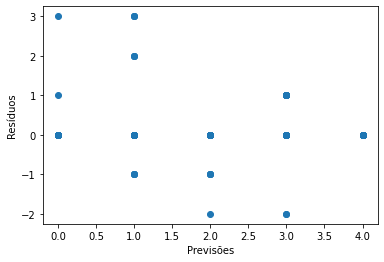

In [35]:
# Analisar os resíduos.
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## XGBoost

In [36]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [37]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.90
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        19
           1       0.90      0.89      0.89        61
           2       0.92      1.00      0.96        61
           3       0.88      0.94      0.91        52
           4       0.97      0.78      0.86        41

    accuracy                           0.90       234
   macro avg       0.88      0.87      0.87       234
weighted avg       0.90      0.90      0.90       234



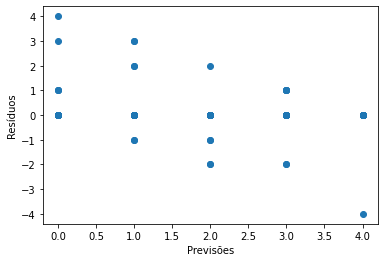

In [38]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

# Treinamento do Modelo

## Bootstraps

In [39]:
n_iterations = 100  # Número de iterações do Bootstrap

# Lista para armazenar as métricas de desempenho em cada iteração
performance_metrics = []

for _ in range(n_iterations):
    # Amostragem Bootstrap: crie um conjunto de treinamento com reamostragem
    indices_amostra = np.random.choice(len(X_treino), size=len(X_treino), replace=True)
    X_bootstrap = X_treino.iloc[indices_amostra]  
    y_bootstrap = Y_treino.iloc[indices_amostra]

    # Crie e treine seu modelo
    model_XGB.fit(X_bootstrap, y_bootstrap)

    # Avalie o modelo no conjunto de teste
    desempenho = model_XGB.score(X_teste, Y_teste)  # Mede a acurácia
    performance_metrics.append(desempenho)

In [40]:
# Calcule as métricas resumidas (por exemplo, média e desvio padrão)
media_desempenho = np.mean(performance_metrics)
desvio_padrao_desempenho = np.std(performance_metrics)

# Imprima as métricas resumidas
print(f'Média do desempenho: {media_desempenho:.4f}')
print(f'Desvio Padrão do desempenho: {desvio_padrao_desempenho:.4f}')

Média do desempenho: 0.8632
Desvio Padrão do desempenho: 0.0163


# Avaliação do Modelo

## Cross-Validation

In [41]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 88.81%
Intervalo de acurácia: [81.25% ~ 96.36%]


In [43]:
# Calcule a média das pontuações para avaliação de Precisão do modelo
def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean * 100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='precision_macro') # Checar Modelo
intervalo_prec(scores)

Precisão média: 87.33%
Intervalo de Precisão: [78.48% ~ 96.18%]


In [44]:
# Calcule a média das pontuações para avaliação de Recall do modelo
def intervalo_recall(results):
    mean = results.mean()
    dv = results.std()
    print('Recall médio: {:.2f}%'.format(mean * 100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='recall_macro') # Checar Modelo
intervalo_recall(scores)

Recall médio: 83.35%
Intervalo de Recall: [71.77% ~ 94.93%]


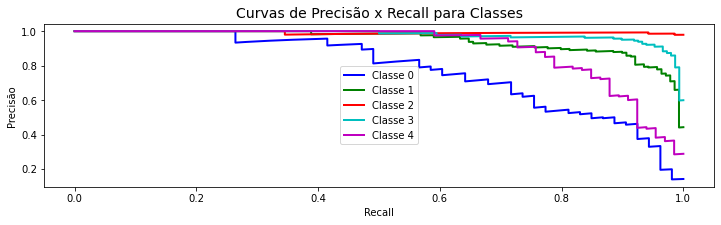

In [45]:
# Comparar scores de Previsão e Recall
# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

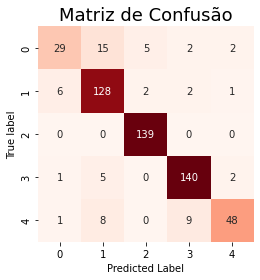

In [46]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [47]:
# Relatório do modelo
print('Relatório de classificação:\n', classification_report(Y_treino, Y_pred, digits=4))

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.7838    0.5472    0.6444        53
           1     0.8205    0.9209    0.8678       139
           2     0.9521    1.0000    0.9754       139
           3     0.9150    0.9459    0.9302       148
           4     0.9057    0.7273    0.8067        66

    accuracy                         0.8881       545
   macro avg     0.8754    0.8283    0.8449       545
weighted avg     0.8865    0.8881    0.8831       545



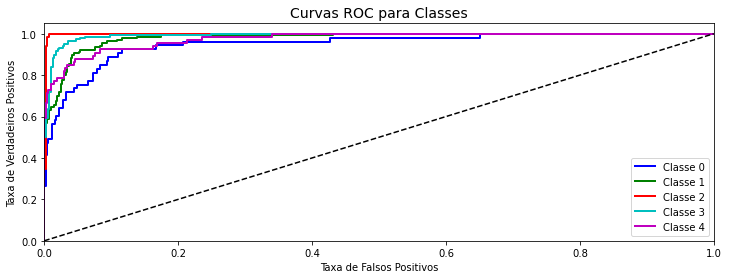

In [48]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para Classes', fontsize=14)
plt.show()

In [49]:
# Área sob a Curva
print('Área sob a curva ROC: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

Área sob a curva ROC: 0.9791


In [50]:
# Treinamento do modelo 
#model_XGB.fit(X_treino, Y_treino) # Checar modelo

# Fazer previsões no conjunto de teste
Y_pred_teste = model_XGB.predict(X_teste)

# Acurácia no conjunto de teste
accuracy = accuracy_score(Y_teste, Y_pred_teste)
print('Acurácia no conjunto de teste: {:.2f}%'.format(accuracy * 100))

# Precisão no conjunto de teste
precision = precision_score(Y_teste, Y_pred_teste, average='macro')
print('Precisão no conjunto de teste: {:.2f}%'.format(precision * 100))

# Recall no conjunto de teste
recall = recall_score(Y_teste, Y_pred_teste, average='macro')
print('Recall no conjunto de teste: {:.2f}%'.format(recall * 100))

# Relatório de classificação no conjunto de teste
print('Relatório de classificação no conjunto de teste:\n', classification_report(Y_teste, Y_pred_teste, digits=4))

Acurácia no conjunto de teste: 87.18%
Precisão no conjunto de teste: 89.77%
Recall no conjunto de teste: 81.23%
Relatório de classificação no conjunto de teste:
               precision    recall  f1-score   support

           0     1.0000    0.5263    0.6897        19
           1     0.8056    0.9508    0.8722        61
           2     0.9524    0.9836    0.9677        61
           3     0.8305    0.9423    0.8829        52
           4     0.9000    0.6585    0.7606        41

    accuracy                         0.8718       234
   macro avg     0.8977    0.8123    0.8346       234
weighted avg     0.8817    0.8718    0.8651       234



## Análise de Variáveis 

In [51]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.18407418 0.0527001  0.04539881 0.07859378 0.07049387 0.04206698
 0.03339072 0.21098006 0.08671675 0.07980835 0.04199637 0.07378001]


<Figure size 1440x1152 with 0 Axes>

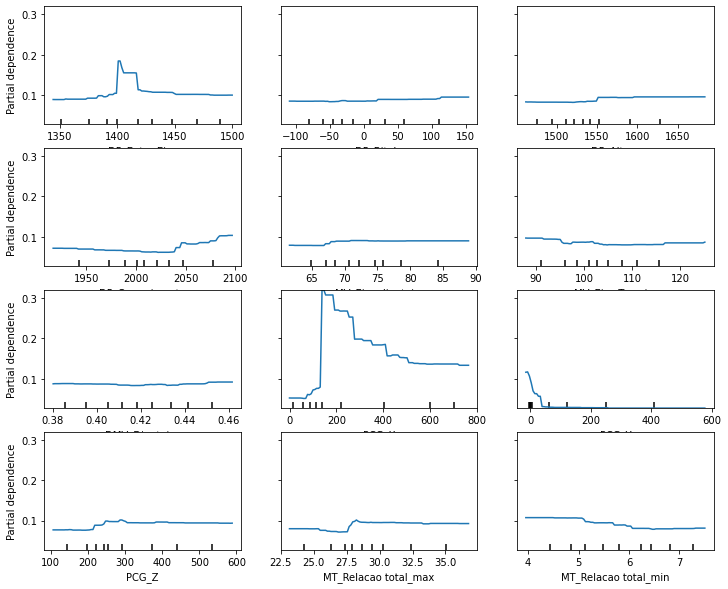

In [52]:
# Analisar como uma variável afeta as previsões
colunas = df.columns[:-1].tolist() # Separar as variáveis

plt.figure(figsize=(20, 16))

# Crie PDPs para as variáveis escolhidas
plot_partial_dependence(model_XGB, X_treino, features=colunas, target=Y_treino.all(), grid_resolution=100)

# Obter a figura atual e definir o tamanho
fig = plt.gcf()
fig.set_size_inches(12, 10)

plt.show()

[20:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[20:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 1150/1170 [00:18<00:00]        

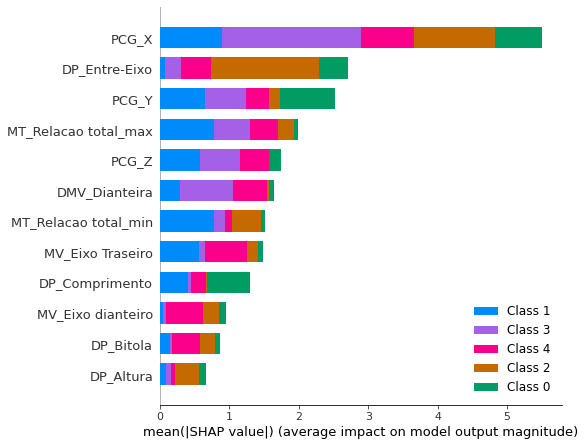

In [53]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Aprimoramento de Parâmetros

## Tuning

In [ ]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores na floresta
    'max_depth': [3, 4, 5],         # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],   # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],   # Fração de amostras usadas para treinamento de cada árvore
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fração de colunas usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],  # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],         # Regularização gamma (parâmetro de penalização)
    'reg_alpha': [0, 0.1, 0.2],     # Regularização L1 (parâmetro de penalização)
    'reg_lambda': [1, 1.1, 1.2]     # Regularização L2 (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [ ]:
# Guardar os parâmetros encontrados fora do código
melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
joblib.dump(melhores_parametros, 'melhores_parametros_sus.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_sus.pkl')

In [ ]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params)

In [ ]:
# Avaliação do desempenho do modelo 
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

## Redução de Dimensão

In [ ]:
# Selecione um número específico de características mais importantes
num_caracteristicas_selecionadas = 3  # Por exemplo, selecione as 3 mais importantes

X_treino_selecionado = X_treino[:, indices_ordenados[:num_caracteristicas_selecionadas]]
X_teste_selecionado = X_teste[:, indices_ordenados[:num_caracteristicas_selecionadas]]

# Em seguida, treine seu modelo no conjunto de dados com características selecionadas
model_XGB.fit(X_treino_selecionado, Y_treino)

In [ ]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

# Predição

In [ ]:
# Valor único para fazer a previsão
X_prev = np.array([6]).reshape(-1, 1) # Colocar os valores pedidos

# Faça a previsão
previsao = modelo_carregado.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')